# Title: Google Play App Store Sentiment Analysis of Customer Reviews

### Data Source
- Kaggle: https://www.kaggle.com/lava18/google-play-store-apps

### Abstract
Each word in the lexicon has scores for:
- polarity: negative vs. positive    (-1.0 => +1.0)
- subjectivity: objective vs. subjective (+0.0 => +1.0)

### Import Libraries

In [247]:
## Import Libraries
import pandas as pd
import regex as re
import spacy
import en_core_web_sm
from string import punctuation
import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

### Load data

In [248]:
file = 'DATA/googleplaystore_user_reviews.csv'
df = pd.read_csv(file)

### Data wrangling and EDA

In [249]:
df.shape

(64295, 5)

In [250]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [252]:
df.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [253]:
# drop rows with null or nan values
df = df.dropna()

In [254]:
# change names of columns
df.columns = ['app', 'review', 'sentiment', 'polarity', 'subjectivity']

In [255]:
df.head()

,app,review,sentiment,polarity,subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [256]:
# Remove app column
df.drop('app', axis='columns', inplace=True)

In [257]:
df

,review,sentiment,polarity,subjectivity
0,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333
1,This help eating healthy exercise regular basis,Positive,0.250000,0.288462
3,Works great especially going grocery store,Positive,0.400000,0.875000
4,Best idea us,Positive,1.000000,0.300000
5,Best way,Positive,1.000000,0.300000
...,...,...,...,...
64222,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,I property business got link SMS happy perform...,Positive,0.800000,1.000000


### Staging for text cleaning

In [258]:
nlp = en_core_web_sm.load()

### Prepare the text

This stage involves all the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle symbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

In [263]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    return text

In [264]:
%%time
text_cleaned = []
for text in df.review:
    text_cleaned.append(clean_text(text))

Wall time: 971 ms


In [265]:
text_cleaned

['I like eat delicious food  That s I m cooking food myself  case 10 Best Foods helps lot  also Best Before  Shelf Life ',
 'This help eating healthy exercise regular basis',
 'Works great especially going grocery store',
 'Best idea us',
 'Best way',
 'Amazing',
 'Looking forward app ',
 'It helpful site   It help foods get  ',
 'good you ',
 'Useful information The amount spelling errors questions validity information shared  Once fixed  5 stars given ',
 'Thank you  Great app   Add arthritis  eyes  immunity  kidney liver detox foods please    ',
 'Greatest ever Completely awesome maintain health     This must ppl there    Love it   ',
 'Good health       Good health first priority       ',
 'Health It s important world either life   think    ',
 'Mrs sunita bhati I thankful developers to make kind app  really good healthy food body',
 'Very Useful in diabetes age 30  I need control sugar  thanks',
 'One greatest apps ',
 'good nice',
 'Healthy Really helped',
 'God health',
 'HEALTH

In [266]:
df.review = text_cleaned

### Work the text
Concern with the meaning and the substance of the content to extract actual information.

In [267]:
def convert_text(text):
    '''
    Remove StopWords, and Lemmatize etc.
    '''
    # remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # remove anything that is not alphanumeric or underscore
    text = re.sub(r'[^\w]', '', text)
    doc = nlp(text)
    converted_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return converted_text

In [ ]:
%%time
text_converted = []
for text in df.review:
    text_converted.append(convert_text(text))

In [128]:
text_converted

['like eat delicious food s m cook food case 10 Best Foods help lot Best Shelf Life',
 'help eat healthy exercise regular basis',
 'work great especially go grocery store',
 'good idea',
 'good way',
 'amazing',
 'look forward app',
 'helpful site   help food',
 'good',
 'useful information spell error question validity information share fix 5 star give',
 'thank great app add arthritis eye immunity kidneyliver detox food',
 'Greatest completely awesome maintain health ppl love',
 'good health good health priority',
 'Health important world life   think',
 'Mrs sunita bhati thankful developersto kind app good healthy food body',
 'useful diabetes age 30 need control sugar thank',
 'great app',
 'good nice',
 'Healthy help',
 'God health',
 'health PRIORITY   MYSG5',
 'excellent useful',
 'find lot wealth form health',
 'find important',
 'Healthy eat',
 'good simply good',
 'test',
 'good',
 'thank advice Downloaded Adobe reader nt recipe book',
 'recipe book unable recipe book',
 'abs

### Perform basic EDA

In [172]:
# this shows the aggregate distinct values of the target variable can be multinomial
df.sentiment.value_counts()

Positive    23998
Negative     8271
Neutral      5158
Name: sentiment, dtype: int64

- Fortunately the dataset is large or there won't be enough training examples of all categories to fit the model

In [173]:
df.dtypes

review           object
sentiment        object
polarity        float64
subjectivity    float64
dtype: object

#### Map code to sentiment

Should we keep the neutral class in our data set since it only is relevent when polarity = 0?

From Wikipedia: "Even though in most statistical classification methods, the neutral class is ignored under the assumption that neutral texts lie near the boundary of the binary classifier, several researchers suggest that, as in every polarity problem, three categories must be identified. Moreover, it can be proven that specific classifiers such as the Max Entropy and SVMs can benefit from the introduction of a neutral class and improve the overall accuracy of the classification."

Source: https://en.wikipedia.org/wiki/Sentiment_analysis

In [174]:
codes = {'Negative':-1, 'Neutral':0, 'Positive':1}

In [186]:
df['sentiment'] = df.sentiment.map(codes)

In [187]:
df.dtypes

review           object
sentiment         int64
polarity        float64
subjectivity    float64
sent_codes        int64
dtype: object

#### Describe distribution

In [191]:
df.describe()

,sentiment,polarity,subjectivity
count,37427.000000,37427.000000,37427.000000
mean,0.420205,0.182171,0.492770
std,0.828029,0.351318,0.259904
min,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.357143
50%,1.000000,0.150000,0.514286
75%,1.000000,0.400000,0.650000
max,1.000000,1.000000,1.000000


<AxesSubplot:>

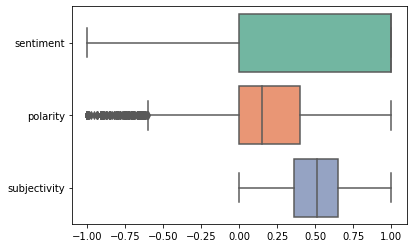

In [221]:
# plot boxplot
sns.boxplot(data=df, orient="h", palette="Set2")

- Polarity is simply the scalar version of sentiment, and hence should only be included in the model to estimate a regressor and of a classifier
- The collinearity between sentiment and polarity is further reinforced by the positive skewness of the boxplots, where outliers towards the negative side of polarity are many.
- Subjectivity denotes the objectivity and subjectivity of text respectively
- Dataset need not be scaled as original values should be preserved to represent the nominal scales

### Selecting features and splitting data

In [177]:
df.corr()

,polarity,subjectivity,sent_codes
polarity,1.000000,0.261587,0.752320
subjectivity,0.261587,1.000000,0.177563
sent_codes,0.752320,0.177563,1.000000


- No surprise that polarity has high correlation with sent_codes
- Subjectivity doesn't add lot of weight to the model and therefore may not be a feature
- However, subjectivity can be a target or set as a punishing feature input to discourage subjective results

In [ ]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)